# Coffea and Awkward

**March 15, 2023 at Beijing**

In [1]:
import awkward as ak
import uproot
import hist
import os
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods.base import NanoEventsArray
from imp import reload #每次修改调用函数后可以更新
import correctionlib, rich

/tmp/ipykernel_144529/982796447.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload #每次修改调用函数后可以更新


### coffea读文件

In [3]:
import input_file 
reload(input_file)
muonc_events = input_file.input_file('data')#5m
zg_events = input_file.input_file('zg')#7m
ttbar_events = input_file.input_file('tt')#8m
zz_events = input_file.input_file('zz')#8m
wz_events = input_file.input_file('wz')#8m
ww_events = input_file.input_file('ww')#9m

data  is done!
zg  is done!
tt  is done!
zz  is done!
wz  is done!
ww  is done!


In [4]:
EVENT = {
    'data':muonc_events,
    'zg': zg_events,
    'tt': ttbar_events,
    'zz': zz_events,
    'wz': wz_events,
    'ww': ww_events,
}

## selection

In [5]:
import selection_cut_test 
reload(selection_cut_test)
event_muon_phodrs = {key: {} for key in EVENT}

for key in EVENT.keys():
    event_muon_phodr = []
    event_variables = []
    for i in EVENT[key]:
#muon_cut
        if key != 'data':
            event_weight = {'event_weight':np.sign(i.Generator.weight)}
        else:
            event_weight =  {'event_weight':'NONE'}
        mu0 = selection_cut_test.muon(i,'num',True)
        mu1 = selection_cut_test.muon(mu0,'trigger','double')
        mu2,event2 = selection_cut_test.muon(mu1,'cutBasedID','tight')
        mu3 = selection_cut_test.muon(mu2,'pf','tight')
        mu4 = selection_cut_test.muon(mu3,'eta','2.4')
        mu5 = selection_cut_test.muon(mu4,'pt',event2)
        mu6 = selection_cut_test.muon(mu5,'pid',True)
        mass = selection_cut_test.MASS(mu6)
        mu_mass = selection_cut_test.muon(mu6,'mass',mass)
#photon_cut
        pho1 = selection_cut_test.photon(mu_mass, 'pt', '35')
        pho2 = selection_cut_test.photon(pho1, 'eta', '2.5')
        pho3 = selection_cut_test.photon(pho2, 'id', 'tight')
        if key == 'data':
            mass = selection_cut_test.MASS(pho3)
            event_variables.append(selection_cut_test.VARIABLES(pho3,mass,key,event_weight))
        else:
            pho4 = selection_cut_test.photon(pho3,'prompt',True)
            gen_photon = pho4.GenPart[(pho4.GenPart.pdgId==22) & pho4.GenPart.hasFlags(['isLastCopy',"isPrompt"])]
            photon4_near, photon4_gen_photon_dr = gen_photon.nearest(pho4.Photon, axis=1, return_metric=True)
            mask = ak.fill_none(photon4_gen_photon_dr < 0.3, True)
            pho5 = pho4[ak.num(pho4.Photon[ak.any(mask == True,axis=1)]) == 1]
            mass = selection_cut_test.MASS(pho5)
            event_variables.append(selection_cut_test.VARIABLES(pho5,mass,key,event_weight))
    event_muon_phodrs[key] = event_variables
    print(key,'event_muon_phodrs',event_muon_phodrs[key])

#data 6m  double 23m  
#zg 9m    double 32m
#tt 54m   double 108m
#zz 69m   double 108m  new 70m
#wz 105m  double 123m new 82m
#ww 119m  double 118m

data event_muon_phodrs [{'photon_pt': <Array [] type='0 * option[var * float32[parameters={"__doc__": "p_{T}"}]]'>, 'photon_eta': <Array [] type='0 * option[var * float32[parameters={"__doc__": "eta"}]]'>, 'muon1_pt': <Array [] type='0 * ?float32[parameters={"__doc__": "pt"}]'>, 'muon2_pt': <Array [] type='0 * ?float32[parameters={"__doc__": "pt"}]'>, 'muon1_eta': <Array [] type='0 * ?float32[parameters={"__doc__": "eta"}]'>, 'muon2_eta': <Array [] type='0 * ?float32[parameters={"__doc__": "eta"}]'>, 'muon_mass': <Array [] type='0 * ?float32'>}, {'photon_pt': <Array [[45.8], [39.9], [93.8], [62.4]] type='4 * option[var * float32[parameter...'>, 'photon_eta': <Array [[-2.41], [-1.06], [2.39], [-0.541]] type='4 * option[var * float32[param...'>, 'muon1_pt': <Array [163, 54.4, 52.1, 29] type='4 * ?float32[parameters={"__doc__": "pt"}]'>, 'muon2_pt': <Array [123, 42.7, 45.2, 27.7] type='4 * ?float32[parameters={"__doc__": "pt"}]'>, 'muon1_eta': <Array [-1.9, 0.42, 0.874, -1.65] type='4 * ?

In [6]:
# 样本名称列表
sample_names = ["data", "zg", "tt", "zz", "ww", "wz"]

# 初始化一个字典，用于存储合并后的数据
event_final = {}

# 遍历每个样本名称
for sample_name in sample_names:
    # 初始化一个字典，用于存储当前样本的合并数据
    event_final[sample_name] = {}

    # 获取第一个条目中的信息键
    info_keys = list(event_muon_phodrs[sample_name][0].keys())

    # 遍历每个信息键
    for info_key in info_keys:
        # 从 event_muon_phodrs 中提取当前样本和信息键的数据
        data_to_concatenate = [entry[info_key] for entry in event_muon_phodrs[sample_name]]

        # 使用 ak.concatenate 将数据连接在一起
        event_final[sample_name][info_key] = ak.concatenate(data_to_concatenate)

print(event_final)


{'data': {'photon_pt': <Array [[45.8], [39.9], ... [48], [39]] type='1419 * option[var * float32[parame...'>, 'photon_eta': <Array [[-2.41], [-1.06], ... [-2.09], [1.65]] type='1419 * option[var * float32...'>, 'muon1_pt': <Array [163, 54.4, 52.1, ... 49, 38.1, 71.7] type='1419 * ?float32[parameters={"...'>, 'muon2_pt': <Array [123, 42.7, 45.2, ... 36, 21.7, 34] type='1419 * ?float32[parameters={"__...'>, 'muon1_eta': <Array [-1.9, 0.42, 0.874, ... 2.29, -0.42] type='1419 * ?float32[parameters={"_...'>, 'muon2_eta': <Array [-1.44, 0.808, 1.96, ... 0.27, -0.151] type='1419 * ?float32[parameters={...'>, 'muon_mass': <Array [287, 90.8, 92.8, ... 83.8, 87.8, 89.3] type='1419 * ?float32'>}, 'zg': {'photon_pt': <Array [[50], [345], ... [75.1], [35.3]] type='10500 * option[var * float32[para...'>, 'photon_eta': <Array [[-1.39], [0.894], ... [-1.77], [2.23]] type='10500 * option[var * float3...'>, 'muon1_pt': <Array [93.4, 129, 26, ... 31.6, 68, 34.8] type='10500 * ?float32[parameters={"_...'>

In [7]:
event_final

{'data': {'photon_pt': <Array [[45.8], [39.9], ... [48], [39]] type='1419 * option[var * float32[parame...'>,
  'photon_eta': <Array [[-2.41], [-1.06], ... [-2.09], [1.65]] type='1419 * option[var * float32...'>,
  'muon1_pt': <Array [163, 54.4, 52.1, ... 49, 38.1, 71.7] type='1419 * ?float32[parameters={"...'>,
  'muon2_pt': <Array [123, 42.7, 45.2, ... 36, 21.7, 34] type='1419 * ?float32[parameters={"__...'>,
  'muon1_eta': <Array [-1.9, 0.42, 0.874, ... 2.29, -0.42] type='1419 * ?float32[parameters={"_...'>,
  'muon2_eta': <Array [-1.44, 0.808, 1.96, ... 0.27, -0.151] type='1419 * ?float32[parameters={...'>,
  'muon_mass': <Array [287, 90.8, 92.8, ... 83.8, 87.8, 89.3] type='1419 * ?float32'>},
 'zg': {'photon_pt': <Array [[50], [345], ... [75.1], [35.3]] type='10500 * option[var * float32[para...'>,
  'photon_eta': <Array [[-1.39], [0.894], ... [-1.77], [2.23]] type='10500 * option[var * float3...'>,
  'muon1_pt': <Array [93.4, 129, 26, ... 31.6, 68, 34.8] type='10500 * ?float32[pa

## ABCD

In [8]:
# 读取 ROOT 文件并获取 TH2D
file_fake_photon_weight = uproot.open("/home/pku/muty/pku/ZGToLLG/run3_zg_analyzer_change/ZG_fakephoton_ABCD/testABCD_weight/fakephoton_weight.root")
hist_fake_photon_weight = file_fake_photon_weight["weight"]

# 将 TH2D 转换为 Awkward Array
fake_photon_weight_array = ak.Array(hist_fake_photon_weight.to_numpy()[0])

# 获取 photon_pt 和 photon_eta
photon_pt = event_final['data']['photon_pt'][:,0]
photon_eta = event_final['data']['photon_eta'][:,0]

# 限制 photon_pt 的最大值
photon_pt = ak.where(photon_pt > 100, 99.9, photon_pt)
#photon_eta = ak.where(photon_eta > 2.5, 2.49, ak.where(photon_eta < -2.5, -2.49, photon_eta))

# 获取 TH2D 的 bin 边缘
xedges = hist_fake_photon_weight.axis(0).edges()
yedges = hist_fake_photon_weight.axis(1).edges()

# 计算 photon_pt 和 photon_eta 的 bin 索引
x_bin_indices = np.digitize(photon_pt, xedges) - 1
y_bin_indices = np.digitize(photon_eta, yedges) - 1

# 使用 bin 索引从 fake_photon_weight_array 中获取权重
fake_photon_weights = fake_photon_weight_array[x_bin_indices, y_bin_indices]



In [9]:
dict_nonpromt = {'nonprompt':event_final['data']}
dict_nonpromt
event_final.update(dict_nonpromt)
event_final['nonprompt']

{'photon_pt': <Array [[45.8], [39.9], ... [48], [39]] type='1419 * option[var * float32[parame...'>,
 'photon_eta': <Array [[-2.41], [-1.06], ... [-2.09], [1.65]] type='1419 * option[var * float32...'>,
 'muon1_pt': <Array [163, 54.4, 52.1, ... 49, 38.1, 71.7] type='1419 * ?float32[parameters={"...'>,
 'muon2_pt': <Array [123, 42.7, 45.2, ... 36, 21.7, 34] type='1419 * ?float32[parameters={"__...'>,
 'muon1_eta': <Array [-1.9, 0.42, 0.874, ... 2.29, -0.42] type='1419 * ?float32[parameters={"_...'>,
 'muon2_eta': <Array [-1.44, 0.808, 1.96, ... 0.27, -0.151] type='1419 * ?float32[parameters={...'>,
 'muon_mass': <Array [287, 90.8, 92.8, ... 83.8, 87.8, 89.3] type='1419 * ?float32'>}

## MuonSFs

In [10]:
BKG = {'zg','nonprompt','tt', 'zz', 'wz', 'ww'}
#BKG = {'tt', 'zz', 'wz', 'ww','nonprompt'}
#SIG = {'zg'}
# LUMI unit is fb
LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83, "run3": 4.5}
XSEC = {
    # unit is pb^-1
    'zg': 55.48,
    'tt': 101.78,
    'ww': 80.27,
    'wz': 29.14,
    'zz': 12.83,
}


In [11]:
# 读取 ROOT 文件并获取 TH2D
file_muonSFs_weight = uproot.open("/home/pku/muty/pku/ZGToLLG/run3_zg_analyzer_change/MuonSFs/Efficiencies_muon_Z_Run2022.root")
#hist_muonSFs_weight = file_muonSFs_weight["NUM_IsoMu24_and_TightID_and_PFIsoTight_DEN_genTracks_eta_pt"]
hist_muonSFs_weight = file_muonSFs_weight["NUM_IsoMu24_DEN_TightID_and_PFIsoTight_eta_pt"]

correction = correctionlib.CorrectionSet.from_file('/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/LUM/2018_UL/puWeights.json.gz')['Collisions18_UltraLegacy_goldenJSON']

weight = {
    i: (
        fake_photon_weights if i == 'nonprompt' else
        (
            correction.evaluate(np.array(event_final[i]['nPU']), "nominal") *
            np.sign(event_final[i]['generator_weight']) * XSEC[i] * LUMI['run3'] * 1e3 / 
            ak.sum(np.sign(event_final[i]['event_weight']))
        )
    ) for i in event_final if i != 'data'
}

# 将 TH2D 转换为 Awkward Array
muonSFs_weight_array = ak.Array(hist_muonSFs_weight.to_numpy()[0])

# 获取 muon1_pt、muon1_eta、muon2_pt 和 muon2_eta
muon1_pt = {i: event_final[i]['muon1_pt'] for i in event_final if i != 'data' and i != 'nonprompt'}
muon1_eta = {i: event_final[i]['muon1_eta'] for i in event_final if i != 'data' and i != 'nonprompt'}
muon2_pt = {i: event_final[i]['muon2_pt'] for i in event_final if i != 'data' and i != 'nonprompt'}
muon2_eta = {i: event_final[i]['muon2_eta'] for i in event_final if i != 'data' and i != 'nonprompt'}

# 限制 muon_pt 的最大值
for key in muon1_pt:
    muon1_pt[key] = ak.where(muon1_pt[key] > 120, 119.9, muon1_pt[key])
    muon2_pt[key] = ak.where(muon2_pt[key] > 120, 119.9, muon2_pt[key])
    muon1_eta[key] = ak.where(muon1_pt[key] > 2.4, 2.39, muon1_eta[key])
    muon2_eta[key] = ak.where(muon2_pt[key] > 2.4, 2.39, muon2_eta[key])

# 获取 TH2D 的 bin 边缘
xedges = hist_muonSFs_weight.axis(0).edges()
yedges = hist_muonSFs_weight.axis(1).edges()

# 计算 muon_eta 和 muon_pt 的 bin 索引
x_bin_indices1 = {key: np.digitize(muon1_eta[key], xedges) - 1 for key in muon1_eta}
y_bin_indices1 = {key: np.digitize(muon1_pt[key], yedges) - 1 for key in muon1_pt}
x_bin_indices2 = {key: np.digitize(muon2_eta[key], xedges) - 1 for key in muon2_eta}
y_bin_indices2 = {key: np.digitize(muon2_pt[key], yedges) - 1 for key in muon2_pt}

# 使用 bin 索引从 muonSFs_weight_array 中获取权重
muonSFs_weights1 = {key: muonSFs_weight_array[x_bin_indices1[key], y_bin_indices1[key]] for key in x_bin_indices1}
muonSFs_weights2 = {key: muonSFs_weight_array[x_bin_indices2[key], y_bin_indices2[key]] for key in x_bin_indices2}

# 计算总的 muonSFs 权重
muonSFs_weights = {}
for key in muonSFs_weights1:
    muonSFs_weights[key] = muonSFs_weights1[key] + muonSFs_weights2[key] - muonSFs_weights1[key] * muonSFs_weights2[key]

# 将 Muon SFs 权重应用于 MC 事件
for key in event_final:
    if key != 'data' and key != 'nonprompt':
        weight[key] = weight[key] * muonSFs_weights[key]



In [ ]:
max(event_final['zg']['muon2_eta'])

## plot

In [19]:
BKG = {'tt', 'zz', 'wz', 'ww','nonprompt','zg'}
#BKG = {'tt', 'zz', 'wz', 'ww','nonprompt'}
#SIG = {'zg'}
# LUMI unit is fb
LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83, "run3": 4.5}
XSEC = {
    # unit is pb^-1
    'zg': 55.48,
    'tt': 101.78,
    'ww': 80.27,
    'wz': 29.14,
    'zz': 12.83,
}

# * xs_weight * pu_weight

In [20]:
correction = correctionlib.CorrectionSet.from_file('/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/LUM/2018_UL/puWeights.json.gz')['Collisions18_UltraLegacy_goldenJSON']
weight = {
    i: (
        fake_photon_weights if i == 'nonprompt' else
        (
            np.sign(event_final[i]['generator_weight']) * XSEC[i] * LUMI['run3'] * 1e3 / 
            ak.sum(np.sign(event_final[i]['event_weight']))
        )
    ) for i in event_final if i != 'data'
}

In [16]:
weight

{'zg': <Array [0.152, -0.17, 0.169, ... -0.166, 0.175] type='10500 * ?float64'>,
 'tt': <Array [0.00622, 0.00636, ... 0.0054, 0.00553] type='4674 * ?float64'>,
 'zz': <Array [0.0557, 0.0316, ... 0.0481, 0.0511] type='67 * ?float64'>,
 'ww': <Array [0.00643, 0.00653, ... 0.00576, 0.00742] type='703 * ?float64'>,
 'wz': <Array [0.00469, 0.00475, ... 0.00469, 0.00476] type='4311 * ?float64'>,
 'nonprompt': <Array [0.0532, 0.0656, ... 0.0532, 0.0262] type='1419 * float64'>}

In [12]:
event_final_2 = {
    'data':event_final['data'],
    'tt':event_final['tt'],
    'ww':event_final['ww'],
    'wz':event_final['wz'],
    'zz':event_final['zz'],
    'nonprompt':event_final['nonprompt'],
    'zg':event_final['zg'],
}

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    return np.array([down_error_bar, up_error_bar])

#weight={y: {c: events[y][c].event_weight for c in events[y] if c!='data' and len(events[y][c])>0} for y in events}


In [14]:
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter

hep.style.use("CMS")
#mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab20").colors)
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='run3', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, fraction_log=False):
    density = False
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
      
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}

    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
#        if k!='data' and k!= 'nonprompt' and weight is not None:
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
#            if k=='nonprompt':
        else:
            hist.fill(values)


        
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var
            

    ## plot
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=['darkorange', 'cyan', 'HotPink', 'darkviolet', 'SlateGray', 'black', 'LightSkyBlue'])
#    SIG_COLOR={'zg': 'red'}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # we usually don't care error of background MC cuz the stats is very large (relative error is very small compared with signal and data)
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
        elif k == 'nonprompt':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
        else:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
    #        hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])

    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))

    
    if not density:
        ax.set_yscale('log')
#    ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2.4)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    ax1.ticklabel_format(useOffset=False, style='scientific')

    # xticks = np.arange(x_min, x_max + 1,20)  # 根据需要调整间隔
    # xticklabels = [str(tick) for tick in xticks]
    # ax1.set_xticks(xticks)
    # ax1.set_xticklabels(xticklabels, fontsize=16)   

#    ax1.set_xticks(ax.get_xticks())
#    ax1.set_xticklabels(ax.get_xticklabels())

    plt.xticks(size=16)
    plt.yticks(size=16)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}_ABCD_muonSFs.pdf", bbox_inches='tight')
    plt.show()

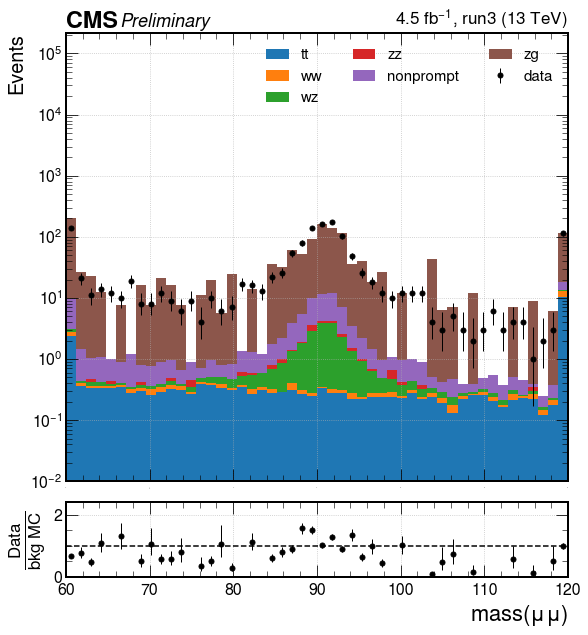

In [21]:
arrays={
    k: event_final_2[k]['muon_mass'] for k in event_final_2 
#    k: event_final_2[k]['photon_eta'][:,0] for k in event_final_2 
}
data_mc_compare_plot(arrays, weight=weight, plot_name='muon_mass', x_name=r'$mass (\mu \mu)$', x_max=120, x_min=60, bins=50, year='run3', density=True, underflow=True)

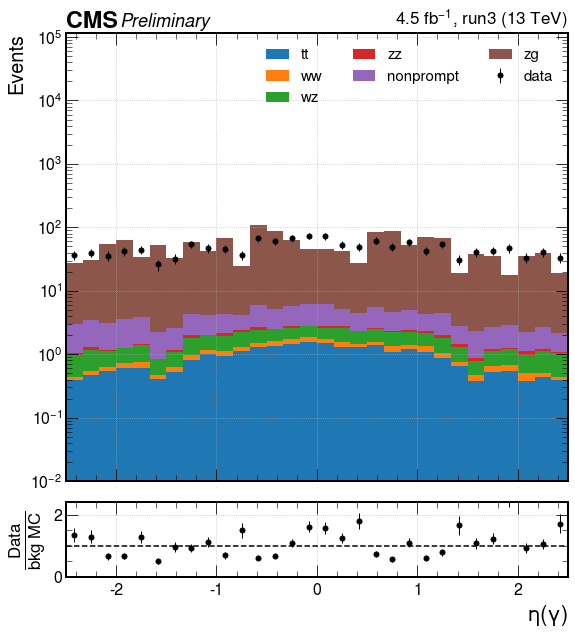

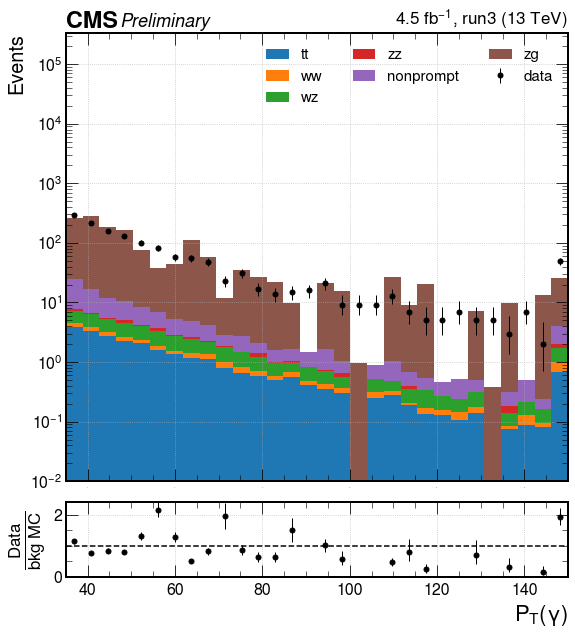

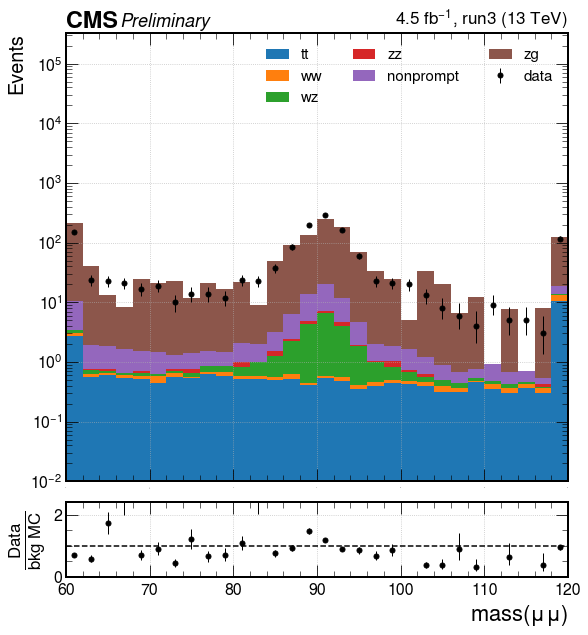

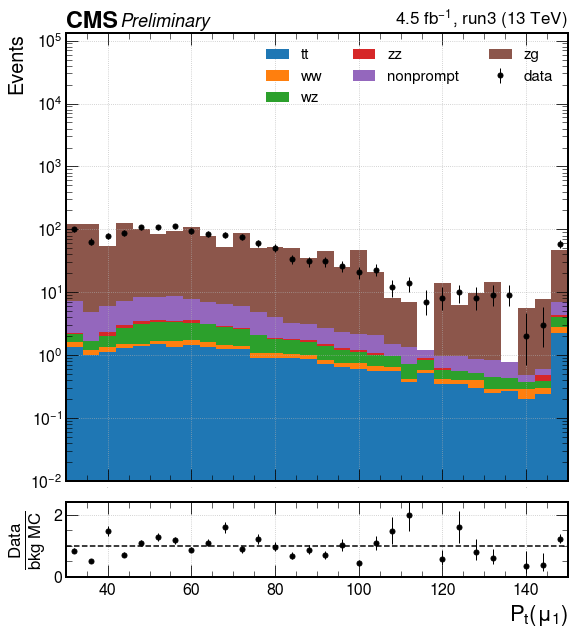

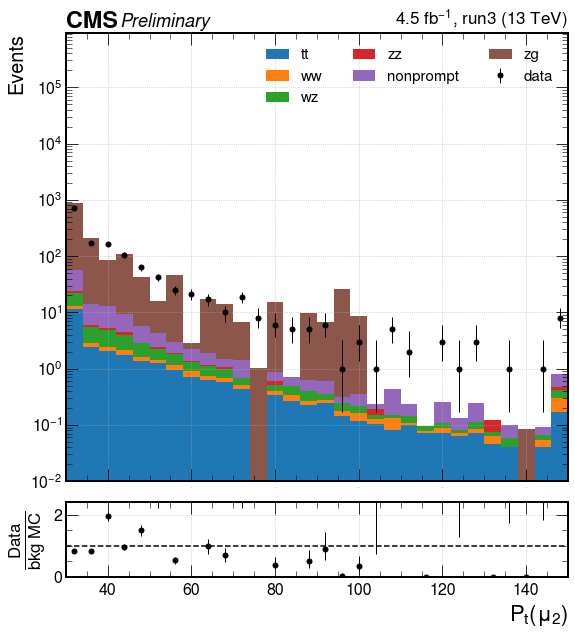

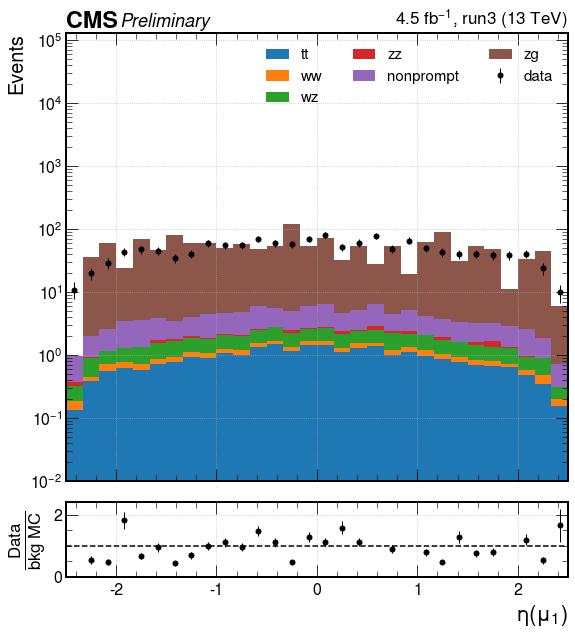

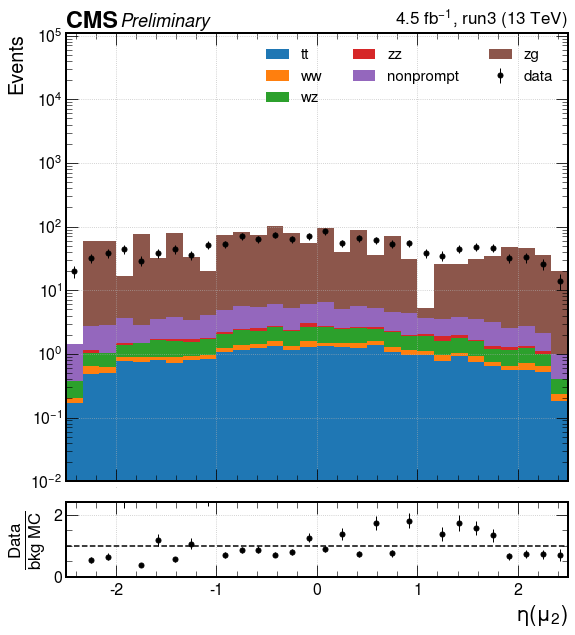

In [17]:
plot_info = [
    ('photon_eta', r'$\eta (\gamma)$', 'photon_eta', -2.5, 2.5, 30, True),
    ('photon_pt', r'$P_T (\gamma)$', 'photon_pt', 35, 150, 30, True),
    ('muon_mass', r'$mass (\mu \mu)$', 'muon_mass', 60, 120, 30, False),
    ('muon1_pt', r'$P_t (\mu_1)$', 'muon1_pt', 30, 150, 30, False),
    ('muon2_pt', r'$P_t (\mu_2)$', 'muon2_pt', 30, 150, 30, False),
    ('muon1_eta', r'$\eta (\mu_1)$', 'muon1_eta', -2.5, 2.5, 30, False),
    ('muon2_eta', r'$\eta (\mu_2)$', 'muon2_eta', -2.5, 2.5, 30, False),
]

for plot_name, x_name, var_name, x_min, x_max, bins, is_photon in plot_info:
    arrays = {k: event_final_2[k][var_name] for k in event_final_2}
    if is_photon:
        arrays = {k: v[:, 0] for k, v in arrays.items()}
    
    data_mc_compare_plot(arrays, weight=weight, plot_name=plot_name, x_name=x_name, x_min=x_min, x_max=x_max, bins=bins, year='run3', density=True, underflow=True)


In [ ]:
event_test = ak.concatenate(event_muon_phodrs['wz'])



In [ ]:
event_muon_phodrs['zg'][0]
event_muon_phodrs['zg'][1]
#122708-26099-5691

In [ ]:
ak.max(event_final.ntuple.Generator_weight)

In [ ]:

"""
lumi = 4.9 fb
"""

xs_weight = lumi * xsec / ak.sum(genWeight)


## 测试

In [ ]:
event_final = {key: {} for key in EVENT}
#print(event_final)
for key in EVENT.keys():
#    event_final[key] = ak.concatenate(ak.Array(event_muon_phodrs[key]))
    event_final[key] = ak.concatenate(event_muon_phodrs[key])
    print(key,'done')
event_final
event_final['data'] = event_final['muonc']
del event_final['muonc']

In [ ]:
import selection_cut 
reload(selection_cut)
i = EVENT['zg'][0]
mu1 = selection_cut.muon(i,'trigger','IsoMu24')
print(mu1)
mu2 = selection_cut.muon(mu1,'cutBasedID','tight')
print(mu2)
mu3 = selection_cut.muon(mu2,'pf','tight')
print(mu3)
mu4 = selection_cut.muon(mu3,'pid','+-')
print(mu4)
mu5 = selection_cut.muon(mu4,'pt','2025')
print(mu5)
mu6 = selection_cut.muon(mu5,'eta','2.4')
print(mu6)
#    event_muon_phodr.append(mu6)
#photon_cut
pho1 = selection_cut.photon(mu6, 'pt', '10')
print(pho1)
pho2 = selection_cut.photon(pho1, 'eta', '2.5')
print(pho2)
pho3 = selection_cut.photon(pho2, 'id', 'tight')
print(pho3)
pho4 = selection_cut.photon(pho3,'prompt',True)
print(pho4)
gen_photon = pho4.GenPart[(pho4.GenPart.pdgId==22) & pho4.GenPart.hasFlags([ "isPrompt", 'isLastCopy'])]
photon4_near, photon4_gen_photon_dr = gen_photon.nearest(pho4.Photon, axis=1, return_metric=True)
mask = ak.fill_none(photon4_gen_photon_dr < 0.3, True)
pho5 = pho4[ak.num(pho4.Photon[ak.any(mask == True,axis=1)]) == 1]
#pho5 = pho4[ak.num(pho4.Photon[mask]) == 1]
print(pho5)

In [ ]:
pho5.Muon.pt
#pho5.Muon[:,1]

In [ ]:
muon_vectors = ak.zip(
    {
        "pt": pho5["Muon"]["pt"],
        "eta": pho5["Muon"]["eta"],
        "phi": pho5["Muon"]["phi"],
        "mass": pho5["Muon"]["mass"],
    },
    with_name="PtEtaPhiMLorentzVector",
)

# 确保每个事件都有两个 muon
muon_pairs = muon_vectors[ak.num(muon_vectors) == 2]

# 计算两个 muon 的联合不变质量
invariant_mass = (muon_pairs[:, 0] + muon_pairs[:, 1]).mass

print("Invariant mass:", invariant_mass)
invariant_mass
#pho5

In [ ]:
mask = ak.fill_none(photon4_gen_photon_dr < 0.3, True)
print(mask)
pho4[ak.num(pho4.Photon[ak.any(mask == True,axis=1)]) == 1]
#pho4.Photon
#ak.num(pho4.Photon[mask])
#pho4
#pho5 = pho4[ak.num(pho4.Photon[mask]) == 1]
#print(pho5)

In [ ]:
event_muon_phodr = []
photon4_near, photon4_gen_photon_dr = gen_photon.nearest(pho4.Photon, axis=1, return_metric=True, threshold=0.003)
photon4_near.charge
mask = ak.fill_none(photon4_gen_photon_dr < 0.3, True)
mask
#[photon4_near.charge == None]

pho5 = pho4[ak.num(pho4.Photon[mask]) == 1]
VARIABLES = {
    'photon_pt':pho5.Photon.pt,
    'photon_eta':pho5.Photon.eta,
#    'tt': ttbar_events,
#    'zz': zz_events,
#    'wz': wz_events,
#    'ww': ww_events,
}
event_muon_phodr.append(VARIABLES)
event_muon_phodr
#event_muon_phodrs[zg] = VARIABLES

In [ ]:
VARIABLES = {
    'photon_pt':pho5.Photon.pt,
    'photon_eta':pho5.Photon.eta,
#    'tt': ttbar_events,
#    'zz': zz_events,
#    'wz': wz_events,
#    'ww': ww_events,
}

In [ ]:
photon4_near, photon4_gen_photon_dr = gen_photon.nearest(pho4.Photon, axis=1, return_metric=True)#, threshold=0.3
ak.fill_none(photon4_gen_photon_dr < 0.3, False)
#pho4[ak.num(photon4_near) != 0]

In [ ]:
ak.min(ak.num(gen_photon))

In [ ]:
reload(selection_cut)
event_muon_pho = []
for event_muon_x in event_muon:
    pho1 = selection_cut.photon(event_muon_x,'pt','10')
    pho2 = selection_cut.photon(pho1,'eta','2.5')
    pho3 = selection_cut.photon(pho2,'id','tight')
    pho4 = selection_cut.photon(pho3,'prompt',True)
    event_muon_pho.append(pho4)

In [ ]:
reload(selection_cut)
event_muon_phodr = []
for event_muon_pho_x in event_muon_pho:
    gen_photon = event_muon_pho_x.GenPart[(event_muon_pho_x.GenPart.pdgId==22) & event_muon_pho_x.GenPart.hasFlags(["fromHardProcess", "isPrompt"])]
    dr_photon = selection_cut.DR(event_muon_pho_x.Photon, gen_photon, drmin=0.3)
    dr_cut = (ak.num(event_muon_pho_x.Photon[dr_photon]) != 0)
    event_muon_phodr.append(event_muon_pho_x[dr_cut])

In [ ]:
reload(selection)
p = selection.DR(c.Photon, gen_photon, drmin=0.3)
dr_cut = (ak.num(c.Photon[p]) != 0)
c[dr_cut]


In [ ]:
p

In [ ]:
b.GenPart.hasFlags(["fromHardProcess", "isPrompt"])

In [ ]:
_events.Photon[0,0].delta_r(gen_photon)

In [ ]:

def muon(sample,cut_name,tag):
    if cut_name == 'trigger':
        if tag == 'IsoMu24':
            return sample[sample.HLT.IsoMu24]
    if cut_name == 'cutBasedID':
        if tag == 'tight':
            cutBasedID_raw = ak.unzip(sample.ntuple.muon_cutBasedID[:,0,:])
            cutBasedID_raw = ak.flatten(cutBasedID_raw)
            muon_cutBasedID_cut = cutBasedID_raw[cutBasedID_raw != -10000000]
            return sample[(ak.all(muon_cutBasedID_cut[:,:] == 3, axis=1))]
    if cut_name == 'pf':
        if tag == 'tight':
            return sample[(ak.all(sample.Muon.pfRelIso04_all[:,:] < 0.15, axis=1))]
    if cut_name == 'pid':
        if tag == '+-':
            pid_raw = ak.unzip(sample.ntuple.muon_pid[:,0,:])
            pid_raw = ak.flatten(pid_raw)
            pid_cut = pid_raw[  (pid_raw == 13) | (pid_raw == -13)]
            return sample[ak.sum(pid_cut[:,:2], axis=1)==0 ]
    if cut_name == 'pt':
        if tag == '2025':
            pt_raw = ak.unzip(sample.ntuple.muon_pt[:,0,:])
            pt_raw = ak.flatten(pt_raw)
            pt_cut = pt_raw[pt_raw != -1e+07]
            return sample[(ak.all(pt_cut[:,:] > 20, axis=1)) & (ak.any(pt_cut[:,:] > 25, axis=1))]
    if cut_name == 'eta':
        if tag == '2.4':
            eta_raw = ak.unzip(sample.ntuple.muon_eta[:,0,:])
            eta_raw = ak.flatten(eta_raw)
            eta_cut = eta_raw[eta_raw != -1e+07]
            return  sample[(ak.all(eta_cut[:,:] < 2.4, axis=1))] 

        


In [ ]:
def photon(sample,cut_name,tag):
    if cut_name == 'pt':
        if tag == '10':
            photon_pt = ak.unzip(sample.ntuple.photon_pt[:,0,:])
            photon_pt = ak.flatten(photon_pt)
            pt_cut = photon_pt[photon_pt != -1e+07]
            return sample[(ak.any(pt_cut[:,:] > 10, axis=1))]
    if cut_name == 'eta':
        if tag =='2.5':
            photon_eta = ak.unzip(sample.ntuple.photon_eta[:,0,:])
            photon_eta = ak.flatten(photon_eta)
            eta_cut = photon_eta[photon_eta != -1e+07]
            return sample[(ak.any(eta_cut[:,:] < 2.5, axis=1))]
    if cut_name == 'id':
        if tag == 'tight':
            pt_id = (sample.Photon.vidNestedWPBitmap[:] & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 1) & 1) 
            scEta_id = (sample.Photon.vidNestedWPBitmap[:] >> 2 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 3) & 1) 
            HoE_id = (sample.Photon.vidNestedWPBitmap[:] >> 4 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 5) & 1) 
            siesie_id = (sample.Photon.vidNestedWPBitmap[:] >> 6 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 7) & 1) 
            chiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 8 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 9) & 1) 
            neuiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 10 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 11) & 1) 
            phoiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 12 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 13) & 1)
            return sample[(ak.any(pt_id ==3, axis = 1)) &  (ak.any(scEta_id ==3, axis = 1)) & (ak.any(HoE_id ==3, axis = 1)) & (ak.any(siesie_id ==3, axis = 1)) & (ak.any(chiso_id ==3, axis = 1)) & (ak.any(neuiso_id ==3, axis = 1)) & (ak.any(phoiso_id ==3, axis = 1))]
    if cut_name == 'prompt':
        photon_prompt = sample.Photon.genPartFlav[sample. Photon.genPartFlav== 1]
        return sample[(ak.all(photon_prompt == 1, axis=1))]






In [ ]:
result2 = []
for zg_event in zg_events:
    mu1 = muon(zg_event,'trigger','IsoMu24')
    mu2 = muon(mu1,'cutBasedID','tight')
    mu3 = muon(mu2,'pf','tight')
    '''
    mu4 = muon(mu3,'pid','+-')
    mu5 = muon(mu4,'pt','2025')
    mu6 = muon(mu5,'eta','2.4')
    '''
    result2.append(mu3)
        

In [ ]:
def processor(events: NanoEventsArray,type) -> ak.Array:
    if type == 'MC':
        print('MC')
        cutBasedID_raw = ak.unzip(events.ntuple.muon_cutBasedID[:,0,:])
        cutBasedID_raw = ak.flatten(cutBasedID_raw)
        muon_cutBasedID_cut = cutBasedID_raw[cutBasedID_raw != -10000000]
        events_cut = events[(events.HLT.IsoMu24) & (ak.all(muon_cutBasedID_cut[:,:] == 3, axis=1)) & (ak.all(events.Muon.pfRelIso04_all[:,:] < 0.15, axis=1))]

    return ak.Array(events_cut)

In [ ]:
result = ak.concatenate([processor(i,'MC') for i in zg_events], axis=0)

In [ ]:
result

In [ ]:
_events = NanoEventsFactory.from_root(
    file='/data/pku/home/muty/pku/ZGToLLG/DATA_MC/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2022/230314_063436/0000/tree_10.root',
    treepath='Events', schemaclass=NanoAODSchema
).events()

In [ ]:
gen_photon

In [ ]:
b.GenPart.statusFlags

In [ ]:
gen_photon = _events.GenPart[
    (_events.GenPart.pdgId==22) &
    _events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
][0, 0]

In [ ]:
gen_photon

In [ ]:
bin(12673)

In [ ]:
_events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy'])

In [ ]:
SFs_file = uproot.open('/home/pku/muty/pku/ZGToLLG/run3_zg_analyzer/MuonSFs/Efficiencies_muon_Z_Run2022.root')
SFs_file['NUM_IsoMu24_and_TightID_and_PFIsoTight_DEN_genTracks_eta_pt'].values()
print(SFs_file['NUM_IsoMu24_and_TightID_and_PFIsoTight_DEN_genTracks_eta_pt'].axes[0].edges())
print(SFs_file['NUM_IsoMu24_and_TightID_and_PFIsoTight_DEN_genTracks_eta_pt'].axes[1].edges())

In [ ]:
#print(_events.Muon.fields)
print(_events.Photon.genPartFlav[0])
#_events.HLT.IsoMu24
#_events.GenMET['phi']
#_events.ntuple['photon_pt'][0,0,:]
#_events.ntuple['GenPart_status']

In [ ]:
for zg_event in zg_events:
    print(zg_event.Photon.genPartFlav[0])

### overflow定义

In [ ]:
def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: ## h, var also include underflow bins but in plots usually no underflow data
        ## And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2]+=h[-1]; var[-2]+=var[-1]
    if underflow:
        h[1]+=h[0]; var[1]+=var[0]
    if overflow or underflow:
        h = h[1:-1]; var = var[1:-1]
    return h, var

## 成功的cut

### muon cut

In [ ]:

def muon(sample,cut_name,tag):
    if cut_name == 'trigger':
        if tag == 'IsoMu24':
            return sample[sample.HLT.IsoMu24]
    if cut_name == 'cutBasedID':
        if tag == 'tight':
            cutBasedID_raw = ak.unzip(sample.ntuple.muon_cutBasedID[:,0,:])
            cutBasedID_raw = ak.flatten(cutBasedID_raw)
            muon_cutBasedID_cut = cutBasedID_raw[cutBasedID_raw != -10000000]
            return sample[(ak.all(muon_cutBasedID_cut[:,:] == 3, axis=1))]
    if cut_name == 'pf':
        if tag == 'tight':
            return sample[(ak.all(sample.Muon.pfRelIso04_all[:,:] < 0.15, axis=1))]
    if cut_name == 'pid':
        if tag == '+-':
            pid_raw = ak.unzip(sample.ntuple.muon_pid[:,0,:])
            pid_raw = ak.flatten(pid_raw)
            pid_cut = pid_raw[  (pid_raw == 13) | (pid_raw == -13)]
            return sample[ak.sum(pid_cut[:,:2], axis=1)==0 ]
    if cut_name == 'pt':
        if tag == '2025':
            pt_raw = ak.unzip(sample.ntuple.muon_pt[:,0,:])
            pt_raw = ak.flatten(pt_raw)
            pt_cut = pt_raw[pt_raw != -1e+07]
            return sample[(ak.all(pt_cut[:,:] > 20, axis=1)) & (ak.any(pt_cut[:,:] > 25, axis=1))]
    if cut_name == 'eta':
        if tag == '2.4':
            eta_raw = ak.unzip(sample.ntuple.muon_eta[:,0,:])
            eta_raw = ak.flatten(eta_raw)
            eta_cut = eta_raw[eta_raw != -1e+07]
            return  sample[(ak.all(eta_cut[:,:] < 2.4, axis=1))] 

        


### photon cut

In [ ]:
def photon(sample,cut_name,tag):
    if cut_name == 'pt':
        if tag == '10':
            photon_pt = ak.unzip(sample.ntuple.photon_pt[:,0,:])
            photon_pt = ak.flatten(photon_pt)
            pt_cut = photon_pt[photon_pt != -1e+07]
            return sample[(ak.any(pt_cut[:,:] > 10, axis=1))]
    if cut_name == 'eta':
        if tag =='2.5':
            photon_eta = ak.unzip(sample.ntuple.photon_eta[:,0,:])
            photon_eta = ak.flatten(photon_eta)
            eta_cut = photon_eta[photon_eta != -1e+07]
            return sample[(ak.any(eta_cut[:,:] < 2.5, axis=1))]
    if cut_name == 'id':
        if tag == 'tight':
            pt_id = (sample.Photon.vidNestedWPBitmap[:] & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 1) & 1) 
            scEta_id = (sample.Photon.vidNestedWPBitmap[:] >> 2 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 3) & 1) 
            HoE_id = (sample.Photon.vidNestedWPBitmap[:] >> 4 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 5) & 1) 
            siesie_id = (sample.Photon.vidNestedWPBitmap[:] >> 6 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 7) & 1) 
            chiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 8 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 9) & 1) 
            neuiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 10 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 11) & 1) 
            phoiso_id = (sample.Photon.vidNestedWPBitmap[:] >> 12 & 1) + 2*((sample.Photon.vidNestedWPBitmap[:] >> 13) & 1)
            return sample[(ak.any(pt_id ==3, axis = 1)) &  (ak.any(scEta_id ==3, axis = 1)) & (ak.any(HoE_id ==3, axis = 1)) & (ak.any(siesie_id ==3, axis = 1)) & (ak.any(chiso_id ==3, axis = 1)) & (ak.any(neuiso_id ==3, axis = 1)) & (ak.any(phoiso_id ==3, axis = 1))]
    if cut_name == 'prompt':
        photon_prompt = sample.Photon.genPartFlav[sample. Photon.genPartFlav== 1]
        return sample[(ak.all(photon_prompt == 1, axis=1))]






In [ ]:
mu1 = muon(_events,'trigger','IsoMu24')
mu2 = muon(mu1,'cutBasedID','tight')

In [ ]:
mu2

In [ ]:
mu1 = muon(_events,'trigger','IsoMu24')
mu2 = muon(mu1,'cutBasedID','tight')
mu3 = muon(mu2,'pf','tight')
mu4 = muon(mu3,'pid','+-')
mu5 = muon(mu4,'pt','2025')
mu6 = muon(mu5,'eta','2.4')

In [ ]:
mu6

In [ ]:
pho1 = photon(mu6,'pt','10')
pho2 = photon(pho1,'eta','2.5')
pho3 = photon(pho2,'id','tight')
pho4 = photon(pho3,'prompt',True)

In [ ]:
#pho4.object = {}
pho4.object

## plot

In [ ]:
set_bins=[100.,150.,200.,300.,400.,500.]
x_min=90 
x_max=501

In [ ]:
def plot(samples, variable, bins=set_bins,overflow=True,underflow=False, density=False, stack=False):
#def plot(samples, variable, bins=[100.,150.,200.,300.,400.,500.],overflow=True,underflow=False, density=False, stack=False):
## canvas initializing
    colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    #f, ax = plt.subplots()
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year=2022, ax=ax)
    #画图定义
#set_bins=[400.,600.,800.,1200.,1600.,2000.,3000.]

#    hep.cms.label(data=False, year=MC, ax=ax)
    plot_weight = {
        'new': 4.9*0.94*1000/791074,
        'old': 4.9*0.96*1000/81266
    }
    plot_hist = {
        'new': bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight()),
        'old': bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight())
    }
    plot_hep = {
        'new': hep,
        'old': hep
    }

## plot
    for key in filedict:
        plot_hist[key].fill(photon_pt[key], weight= events[key]['LHEReweightingWeight'][:,8]*plot_weight[key])
        h, var = flow(hist=plot_hist[key], overflow=overflow, underflow=underflow)
        print(plot_hist[key])
        plot_hep[key].histplot(h, bins=plot_hist[key].axes[0].edges, yerr=np.sqrt(var), label=key, histtype='step', density=density, stack=stack)
        

#    hist = bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight())
#    hist.fill(photon_pt['new'], weight= events['new']['LHEReweightingWeight'][:,8]*139*0.94*1000/791074)
#    h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
#    print(hist)
#    return hist
#    h, err = hist.view().value, np.sqrt(hist.view().variance)

#    hep.histplot(h, bins=hist.axes[0].edges, yerr=np.sqrt(var), label='sm_pt', histtype='step', density=density, stack=stack)
#    print(np.sqrt(var))
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too) 


## axises
    plt.xlim(x_min, x_max)
#    plt.xlim(0, 500)
#    plt.ylim(0, ax.get_ylim()[1]*1.1) 
    ax.ticklabel_format(useOffset=False, style='plain')
    plt.yscale('log') 

    if density==False:
        plt.ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        plt.ylabel('A.U.', fontsize=20, ha='right', y=1)
    plt.xlabel('photon_pt', fontsize=20, ha='right', x=1)

    plt.xticks(size=16)
    plt.yticks(size=16)
    
    ## title, text and legend
    #plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    plt.legend(loc="best", ncol=1, frameon=False, fontsize=20)
    #plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')


    ## finalizing
    if density==True:   suffix='_AU'
    if stack==True:     suffix='_stack'
#    plt.savefig("plots/"+'M_mumu2'+suffix+".pdf", bbox_inches='tight')
    plt.savefig("plot/"+'photon_pt_new'+".pdf", bbox_inches='tight')
    plt.show()
#    return hist

In [ ]:
plot(samples=photon_pt['new'],  variable='nan')
#新物理参数的置信度 新物理参数和标准模型作对比（weight ratio加权） 直方图就是标准模型的结果 二次函数拟合想得到新物理参数和标准模型之间的差异

## 测试的cut

In [ ]:
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

set_bins = [0.,10.,15.,20.,40.,60.,100.,200.]
def plot(samples, bins=set_bins, density=False, stack=False):
#def plot(samples, variable, bins=[100.,150.,200.,300.,400.,500.],overflow=True,underflow=False, density=False, stack=False):
## canvas initializing
    colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    #f, ax = plt.subplots()
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    plt.yscale('log')
    hep.cms.label(data=False, year=2022, ax=ax)
    plot_hist = bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight())
    plot_hist.fill(samples, weight=1)
    h, err = plot_hist.view().value, np.sqrt(plot_hist.view().variance)
    plot_hep = hep
    plot_hep.histplot(h, bins=plot_hist.axes[0].edges, yerr=err, label="muon_pt", histtype='step', density=density, stack=stack)
    plt.show()

In [ ]:
plot(samples=pho4.ntuple.muon_pt[:,0,1])

In [ ]:
####原始cut
#trigger(HLT_IsoMu24)
'''
mu1 = _events[_events.HLT.IsoMu24]
mu1
print(mu1[2].pt)
'''

#Tight CutBased ID & Tight PF isolation for two muons 
'''
cutBasedID_raw = ak.unzip(mu1.ntuple.muon_cutBasedID[:,0,:])
cutBasedID_raw = ak.flatten(cutBasedID_raw)
muon_cutBasedID_cut = cutBasedID_raw[cutBasedID_raw != -10000000]
muon_cutBasedID_pf_cut = (ak.all(muon_cutBasedID_cut[:,:] == 3, axis=1)) & (ak.all(mu1.Muon.pfRelIso04_all[:,:] < 0.15, axis=1))
mu2 = mu1[muon_cutBasedID_pf_cut]
mu2
'''

#two muon and with opposite charge
'''
pid_raw = ak.unzip(mu2.ntuple.muon_pid[:,0,:])
pid_raw = ak.flatten(pid_raw)
pid_cut = pid_raw[  (pid_raw == 13) | (pid_raw == -13)]
muon_pid_cut = ak.sum(pid_cut[:,:2], axis=1)==0 
mu3 = mu2[muon_pid_cut]
mu3
#print(mu2.pt[100])
'''

#all the muons>20，ar least one muon>35 
'''
pt_raw = ak.unzip(mu3.ntuple.muon_pt[:,0,:])
pt_raw = ak.flatten(pt_raw)
pt_cut = pt_raw[pt_raw != -1e+07]
muon_pt_cut = (ak.all(pt_cut[:,:] > 20, axis=1)) & (ak.any(pt_cut[:,:] > 35, axis=1))
mu4 = mu3[muon_pt_cut]
mu4
#print(mu3[2].pt)
'''

#all the eta<2.4 
'''
eta_raw = ak.unzip(mu4.ntuple.muon_eta[:,0,:])
eta_raw = ak.flatten(eta_raw)
eta_cut = eta_raw[eta_raw != -1e+07]
muon_eta_cut = (ak.all(eta_cut[:,:] < 2.4, axis=1)) 
event_mu = mu4[muon_eta_cut]
event_mu
'''

#any photon pt>10 
'''
photon_pt = ak.unzip(event_mu.ntuple.photon_pt[:,0,:])
photon_pt = ak.flatten(photon_pt)
pt_cut = photon_pt[photon_pt != -1e+07]
photon_pt_cut = (ak.any(pt_cut[:,:] > 10, axis=1))
photon1 = event_mu[photon_pt_cut]
photon1
'''

#any photon eta < 2.5 
'''
photon_eta = ak.unzip(photon1.ntuple.photon_eta[:,0,:])
photon_eta = ak.flatten(photon_eta)
eta_cut = photon_eta[photon_eta != -1e+07]
photon_eta_cut = (ak.any(eta_cut[:,:] < 2.5, axis=1))
photon2 = photon1[photon_eta_cut]
photon2
'''


# determine photon id
'''
pt_id = (photon2.Photon.vidNestedWPBitmap[:] & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 1) & 1) 
scEta_id = (photon2.Photon.vidNestedWPBitmap[:] >> 2 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 3) & 1) 
HoE_id = (photon2.Photon.vidNestedWPBitmap[:] >> 4 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 5) & 1) 
siesie_id = (photon2.Photon.vidNestedWPBitmap[:] >> 6 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 7) & 1) 
chiso_id = (photon2.Photon.vidNestedWPBitmap[:] >> 8 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 9) & 1) 
neuiso_id = (photon2.Photon.vidNestedWPBitmap[:] >> 10 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 11) & 1) 
phoiso_id = (photon2.Photon.vidNestedWPBitmap[:] >> 12 & 1) + 2*((photon2.Photon.vidNestedWPBitmap[:] >> 13) & 1) 
#tight photon id
photon_id = (ak.any(pt_id ==3, axis = 1)) &  (ak.any(scEta_id ==3, axis = 1)) & (ak.any(HoE_id ==3, axis = 1)) & (ak.any(siesie_id ==3, axis = 1)) & (ak.any(chiso_id ==3, axis = 1)) & (ak.any(neuiso_id ==3, axis = 1)) & (ak.any(phoiso_id ==3, axis = 1))
photon3 = photon2[photon_id]
photon3
'''

#prompt
'''
photon_prompt = photon3.Photon.genPartFlav[photon3.Photon.genPartFlav == 1]
photon_prompt
photon_prompt_cut = (ak.all(photon_prompt == 1, axis=1))
photon_prompt_cut
photon4 = photon3[photon_prompt_cut]
photon4
'''




In [ ]:
print(ak.all(photon_prompt == 1, axis=1))

In [ ]:
photon_prompt = photon3.Photon.genPartFlav[photon3.Photon.genPartFlav == 1]
photon_prompt
photon_prompt_cut = (ak.all(photon_prompt == 1, axis=1))
photon_prompt_cut
photon4 = photon3[photon_prompt_cut]
photon4


In [ ]:

status_cut = (photon3.GenPart.status == 1) & (abs(photon3.GenPart.pdgId) == 22) | (abs(photon3.GenPart.pdgId) == 11)
status_cut
photon_phi_gen = photon3.GenPart.phi[status_cut]
photon_phi_gen[0]

In [ ]:
one = ak.Array([[1, 2, 3], [], [4, 5], [6]])
two = ak.Array([[1, 2], [3], [4,5,6], [7]])

In [ ]:
print(ak.argcartesian([one, two], axis=1, nested=False))

In [ ]:
x = ak.cartesian([one, two], axis=1, nested=False)

In [ ]:
def DR(A,B):
    return (A-B)**2

In [ ]:
DR(x[0,0],x[0,1])

In [ ]:
h = hist.Hist.new.Reg(120, 0, 120, name="muon_pt").Double()
h

In [ ]:
event_mu.muon_pt

In [ ]:
h.fill(event_mu.muon_pt[:,0,0])

In [ ]:
h.plot();

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
from cycler import cycler
import boost_histogram as bh

In [ ]:
plot_hist = bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight())
err = 

In [ ]:
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

set_bins = [0.,10.,15.,20.,40.,60.,100.,200.]
def plot(samples, bins=set_bins, density=False, stack=False):
#def plot(samples, variable, bins=[100.,150.,200.,300.,400.,500.],overflow=True,underflow=False, density=False, stack=False):
## canvas initializing
    colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    #f, ax = plt.subplots()
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    plt.yscale('log')
    hep.cms.label(data=False, year=2022, ax=ax)
    plot_hist = bh.Histogram(bh.axis.Variable(set_bins), storage=bh.storage.Weight())
    plot_hist.fill(samples, weight= 1)
    h, err = plot_hist.view().value, np.sqrt(plot_hist.view().variance)
    plot_hep = hep
    plot_hep.histplot(h, bins=plot_hist.axes[0].edges, yerr=err, label="muon_pt", histtype='step', density=density, stack=stack)
    plt.show()

In [ ]:
plot(samples=event_mu.muon_pt[:,0,1])

In [ ]:
print(event.photon_status[0])
event.photon_status[0]

In [ ]:
print(event.photon_phi_gen[0])
event.photon_phi_gen[0]

In [ ]:
GenPart_status
status_cut = (event.photon_status == 1) & (abs(event.photon_pdgid) == 22) | (abs(event.photon_pdgid) == 11)
status_cut
photon_phi_gen = event.photon_phi_gen[status_cut]
photon_phi_gen[0]

In [ ]:
print(photon3.photon_status[0])
photon3.photon_status[0]

In [ ]:
print(photon3.photon_phi_gen[0])
photon3.photon_phi_gen[0]

In [ ]:
print(photon3.photon_phi_pho[0])
photon3.photon_phi_pho[0]

In [ ]:
#photon3.photon_pdgid

status_cut = (photon3.photon_status == 1) & (abs(photon3.photon_pdgid) == 22) | (abs(photon3.photon_pdgid) == 11)
status_cut
photon_phi_gen = photon3.photon_phi_gen[status_cut]
photon_phi_gen[0]
#photon_phi_pho = photon3.photon_phi_pho[status_cut]
#photon_eta_gen = photon3.photon_eta_gen[status_cut]
##photon_status_pid
#print(status_cut[0])

In [ ]:
pdg_id = photon3.photon_pdgid[  (abs(photon3.photon_pdgid) == 22) | (abs(photon3.photon_pdgid) == 11)]
#pdg_id = ak.all(abs(photon3.photon_pdgid) == 22 or abs(photon3.photon_pdgid) == 11)
#print(photon3.photon_pdgid[0])
#print(pdg_id[0])
status_cut[pdg_id]


In [ ]:
event_mu.photon_vid[125]

In [ ]:
print(format(15375,'b'))
print(format(16383,'b'))
print(event_mu.photon_vid[125] & 1)
print((event_mu.photon_vid[125] >> 1) & 1)
print((event_mu.photon_vid[125] >> 2) & 1)
print((event_mu.photon_vid[125] >> 3) & 1)
print((event_mu.photon_vid[125] >> 4) & 1)
print((event_mu.photon_vid[125] >> 5) & 1)
print((event_mu.photon_vid[125] >> 6) & 1)
print((event_mu.photon_vid[125] >> 7) & 1)
print((event_mu.photon_vid[125] >> 8) & 1)
print((event_mu.photon_vid[125] >> 9) & 1)
print((event_mu.photon_vid[125] >> 10) & 1)
print((event_mu.photon_vid[125] >> 11) & 1)
print((event_mu.photon_vid[125] >> 12) & 1)
print((event_mu.photon_vid[125] >> 13) & 1)

In [ ]:
#struct.unpack(12)
format(3,'b')
#bitarray(photons.vid[121][:])

In [ ]:
i =42
type(i)

In [ ]:
struct

In [ ]:

binary_data = struct.pack('i', [42,31][0])
print(binary_data)

In [ ]:
photons.vid[121]

In [ ]:
pid_raw = ak.Array([[],[-13,13,-100,-100],[-100,-100,-100,-100],[-100,13,-13,-100],[-100,-100,13,-13],[-100,-100,-100,-100]])
isMuon = pid_raw[pid_raw < 0  ]
isMuon
# b = samples["muonFile"]["ntuple_muon_pid"][samples["muonFile"]["ntuple_muon_pid"] > -999]

In [ ]:
print(mu1.eta[0])
print(mu2.eta[0])


In [ ]:
muons.trigger

In [ ]:
muons[muons.trigger]

In [ ]:
#先解定长数组
pid_raw = ak.unzip(muons.pid_raw[:,0,:])
pid_raw = ak.flatten(pid_raw)
muons.pid = pid_raw[  (pid_raw == 13) | (pid_raw == -13)]
muons.pid

In [ ]:
#test_cut = ak.any(20 < muons.pt[:,0,:]< 35, axis=1)
test_cut = ak.any(muons.pt[:,0,:]>20 & muons.pt[:,0,:]< 35, axis=1)
test_mu = muons[test_cut]
print(mu1.pt[3])

In [ ]:
arr=np.array(muons.pid_raw[:,0,:])
p=ak.Array(arr.astype(int))
p
p[p>-20]

In [ ]:
cut2=(ak.num(muons.pid)==2 & (ak.sum(muons.pid)==0))
p=muons[cut2]
p[1]

In [ ]:
####
p=[]
p.append(muons.pid_raw[1,0,:][muons.pid_raw[1,0,:]>-20])
#p.append(muons.pid_raw[:,0,:][muons.pid_raw[:,0,:]>-20])
p.append(muons.pid_raw[4,0,:][muons.pid_raw[4,0,:]>-20])
p.append(muons.pid_raw[0,0,:][muons.pid_raw[0,0,:]>-20])
ak.Array(np.squeeze(p))

In [ ]:
cut1=(muons.pid != -10000000) 
# (ak.sum(muons.pid[:, 0,:], axis=1) == 0)

In [ ]:
#成功的单一事例cut
cut_test = (muons.pid != -10000000)
cut4=cut_test[20][0]
cut4
muons.pid[20][0][cut4]

In [ ]:
cut_test = (ak.any(muons.pid != -10000000, axis=1)) 
cut4=cut_test[20]
cut4
muons.pid[20][0][cut4]

In [ ]:

muons.pid=muons.pid[ak.sum(muons.pid > -20)==0]
muons.pid

In [ ]:
muons.pid

In [ ]:
cut_test = (muons.pid != -10000000)
cut4=cut_test[:][:]
cut4

In [ ]:
muons.pid[:][:][cut4]

In [ ]:
muons

In [ ]:
print(mu1.pt[0])


A cut is an array of booleans, which we can construct as a formula.

In [ ]:
cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
cut

Applying a cut is a slice. In the same slice, we can pick the first (`0`) and second (`1`) muon in each event.

In [ ]:
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]
mu1, mu2

Let's use the [hist](https://github.com/scikit-hep/hist#readme) library for histograms.

In [ ]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h

In [ ]:
h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

And Matplotlib for plots.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
h.plot();

<br><br><br><br><br>

Now let's do the whole thing in one cell and time it.

In [ ]:
starttime = time.time()

# read data
muons = events.arrays(
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"},
    array_cache=None,   # no cheating!
)

# compute
cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

uproot_time = time.time() - starttime
print(f"total time: {uproot_time} sec")

In [ ]:
pyroot_time / uproot_time

It's in the same ballpark as C++. It can be 1.5× to 2× slower, but it's much closer to C++ on a log plot than it is to Python "for" loops.

<br><br><br><br><br>

## The Pythonic HEP ecosystem

Uproot is not a framework, it _only_ does ROOT I/O. Awkward Array handles array manipulation, hist does histograms, etc.

It is part of this complete breakfast:

<img src="img/logo-parade.svg" width="800px">

<br><br><br><br><br>

## Uproot

Uproot is an independent implementation of ROOT I/O that leverages standard Python libraries.

<img src="img/abstraction-layers.svg" width="800px">

<br><br><br><br><br>

The documentation is at [https://uproot.readthedocs.io/](https://uproot.readthedocs.io/).

<img src="img/uproot-documentation.png" width="800px"/>

<br><br><br><br><br>

## Navigating a ROOT file

<img src="img/terminology.svg" style="width: 800px">

In [ ]:
histograms = uproot.open("data/HiggsZZ4mu_histograms.root")
histograms

In [ ]:
histograms.file

In Uproot, a directory is a dict-like object with subscripting (square brackets), [keys](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#keys), [values](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#values), [items](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#items), and [classnames](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#classnames) methods.

In [ ]:
histograms["Z"]

In [ ]:
histograms["Z"]["4mu"]

Try `recursive`, `filter_name`, and `filter_classname` arguments.

In [ ]:
histograms.keys()

Most histograms and graphs can be converted to types in other Python libraries.

Try the `to_hist()` method on this one.

In [ ]:
histograms["Z/all/massZto2muon"]

<br><br><br>

**Three-minute exercise:** find the 2D histogram and plot it.

In [ ]:
histograms

<br><br><br><br><br>

## Can Uproot read my data?

<img src="img/can-uproot-read-it.svg" width="500px"/>

Here is a file with analysis-specific classes; Uproot _cannot_ have prior knowledge of these classes.

In [ ]:
icecube = uproot.open("data/icecube-supernovae.root")
icecube.keys()

In [ ]:
icecube.classname_of("config/detector")

It is possible to read an `I3Eval_t` object because ROOT stores the "how to read" instructions in the file (called "streamers").

In [ ]:
icecube.file.show_streamers("I3Eval_t")

In [ ]:
icecube["config/detector"]

In [ ]:
icecube["config/detector"].all_members

In [ ]:
icecube["config/detector"].member("ChannelIDMap")

Unlike histograms, these objects have no methods to help you unpack the data; it's all in [members](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#members), [all_members](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#all-members), [has_member](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#has-member), and [member](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#member).

<br><br><br><br><br>

## Navigating TTrees

In [ ]:
zmumu_file = uproot.open("data/Zmumu.root")
zmumu_file.classnames()

Often, the best thing to do first with an unfamiliar TTree is [show](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#show).

In [ ]:
zmumu = zmumu_file["events"]
zmumu.show()

Keep in mind that

   * TTrees are dict-like objects with subscripting (square brackets), [keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#keys), [values](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#values), [items](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#items), and [typenames](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#typenames) methods (like directories)
   * you can access all of the above data with methods: you don't have to parse the [show](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#show) string!

In [ ]:
zmumu.keys()

In [ ]:
zmumu.typenames()

In [ ]:
{name: branch.interpretation for name, branch in zmumu.items()}

<br><br><br><br><br>

## Reading TBranches into arrays

The basic method is to get a TBranch (with square brackets) and call [array](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#array).

In [ ]:
zmumu["M"].array()

Some important parameters:

   * `entry_start`, `entry_stop` to limit how much you read (if it's big)
   * `library="np"` for NumPy arrays, `library="ak"` for Awkward Arrays, and `library="pd"` for Pandas (Series or DataFrame)

In [ ]:
zmumu["M"].array(entry_stop=5)

Get a NumPy (not Awkward) array:

In [ ]:
zmumu["M"].array(library="np")

Get a Pandas Series:

In [ ]:
zmumu["M"].array(library="pd")

<br><br><br><br><br>

## Reading many arrays at once

The [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays) method retrieves many TBranches into a "group" of arrays.

What a "group" means depends on the library.

Awkward Arrays group data in records (substructure within the array).

In [ ]:
zmumu.arrays()

A "group" of NumPy arrays is a dict (unless you specify `how`):

In [ ]:
zmumu.arrays(library="np")

A "group" of Pandas Series is a DataFrame:

In [ ]:
zmumu.arrays(library="pd")

The first argument can be used to extract TBranches by name:

In [ ]:
zmumu.arrays(["px1", "py1", "px2", "py2"], library="pd")

But this argument actually takes arbitrary (Python) expressions.

In [ ]:
zmumu.arrays(["sqrt(px1**2 + py1**2)", "sqrt(px2**2 + py2**2)"], library="pd")

This is to support any [aliases](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#aliases) that might be in the [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html), but you can make up your own `aliases` on the spot.

In [ ]:
zmumu.arrays(
    ["pt1", "pt2"],
    {"pt1": "sqrt(px1**2 + py1**2)", "pt2": "sqrt(px2**2 + py2**2)"},
    library="pd",
)

The fact that these are interpreted as expressions has some "gotchas":

   * nested branches, paths with "`/`", _would be interpreted as division!_
   * wildcards, paths with "`*`", _would be interpreted as multiplication!_

For pattern-matching on TBranches, use the `filter_name`, `filter_typename`, and `filter_branch` arguments of [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays).

In [ ]:
zmumu.arrays(filter_name="p[xyz]*", library="pd")

These filters have the same meaning as in [keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#keys) and [typenames](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#typenames), so you can test your filters without reading data.

In [ ]:
zmumu.keys(filter_name="p[xyz]*")

In [ ]:
zmumu.typenames(filter_name="p[xyz]*")

<br><br><br>

### Get arrays in manageable chunks

The [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#iterate) method is like [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays), but it can be used in a loop over chunks of the array.

How large are the chunks? You should set that with `step_size`.

In [ ]:
for arrays in zmumu.iterate(step_size=300):
    print(repr(arrays))

In [ ]:
for arrays in zmumu.iterate(step_size="50 kB"):   # 50 kB is very small! for illustrative purposes only!
    print(repr(arrays))

<br><br><br>

### Collections of files (like TChain)

Each of the single-TTree array-reading methods has a corresponding multi-file function.

   * The equivalent of TTree [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) is [uproot.concatenate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.concatenate.html). _(Reads everything at once: use this as a convenience on datasets you know are small!)_
   * The equivalent of TTree [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#iterate) is [uproot.iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html). _(This is the most useful one.)_
   * There's also an [uproot.lazy](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.lazy.html) _(More on this below.)_

Demo of scanning through a large (remote) file:

In [ ]:
import IPython
import matplotlib.pyplot as plt
import matplotlib.pylab

In [ ]:
h = hist.Hist.new.Reg(100, 0, 500, name="mass").Double()

for muons in uproot.iterate(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],

    # expressions
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"},    

    # the all-important step_size!
    step_size="1 MB",
):
    # do everything you're going to do to this array
    cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
    mu1 = muons[cut, 0]
    mu2 = muons[cut, 1]

    # such as filling a histogram
    h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

    h.plot()
    plt.yscale("log")
    IPython.display.display(matplotlib.pylab.gcf())
    IPython.display.clear_output(wait=True)

    if h.counts().sum() > 300000:
        break

<br><br><br><br><br>

Lazy reading is like iterative reading, but it fetches the data only when needed.

In [ ]:
lazy = uproot.lazy(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],
    # step_size is still important
    step_size="1 MB",
)
lazy

In [ ]:
lazy.Muon_pt

In [ ]:
lazy.Muon_eta

**Important:** this is not the most efficient way to iterate through a file when you _know_ which TBranches you want to read.

It exists for interactive exploration.

<br><br><br><br><br>

## What if the data are not one-dimensional or rectilinear arrays?

Consider this ROOT file (simulation used in the Higgs discovery, converted to NanoAOD).

In [ ]:
events = uproot.open("data/HiggsZZ4mu.root:Events")

Some data, such as missing energy (MET), consist of a single value per collision event and can be represented by normal NumPy arrays.

In [ ]:
nonjagged = events["MET_pt"].array(entry_stop=20, library="np")
nonjagged

Normal NumPy slicing rules apply.

In [ ]:
nonjagged[:5]

<br><br><br><br><br>

Some data cannot. There's a different number of muons in each event, so we need variable-length nested lists to represent their transverse momenta ($p_T$).

In [ ]:
jagged_awkward = events["Muon_pt"].array(entry_stop=20)
jagged_awkward

In [ ]:
jagged_awkward.tolist()

It is _possible_ to read these data into NumPy, but with a considerable cost.

In [ ]:
jagged_numpy = events["Muon_pt"].array(entry_stop=20, library="np")
jagged_numpy

This is an _array of NumPy arrays_ (because you can put Python objects in NumPy arrays—not recommended).

You might want to consider the inner arrays to be a second dimension and use normal slicing rules:

In [ ]:
jagged_awkward[:, :1]

In [ ]:
jagged_numpy[:, :1]

In NumPy, you can't. NumPy doesn't know that all the contents of this array are arrays of the same type.

You know this and can write a loop in Python:

In [ ]:
np.array([x[:1] for x in jagged_numpy])

But this isn't recommended. It's non-idiomatic and slow.

<br><br><br><br><br>

Pandas can work with this "jagged" data through indexing.

In [ ]:
events.arrays(filter_name=["Muon_*"], library="pd")

But there are limitations. Try loading non-muon branches in the same DataFrame.

<br><br><br><br><br>

## Awkward Array

Awkward Array is a library for manipulating JSON-like data using NumPy-like idioms.

<img src="img/cartoon-schematic.svg" width="800px"/>

<br><br><br><br><br>

The documentation is at [https://awkward-array.org/](https://awkward-array.org/).

<img src="img/awkward-documentation.png" width="800px"/>

<br><br><br><br><br>

Consider this Parquet file of the same dataset. It can be read into an Awkward Array, just like the ROOT file.

In [ ]:
array = ak.from_parquet("data/HiggsZZ4mu.parquet")
array

In [ ]:
array.fields

In [ ]:
array[0].tolist()

In [ ]:
array.muons.pt

<br><br><br><br><br>

I've restructured it a little ("NanoEvents-style" vs "NanoAOD-style"), but we can easily make the data from ROOT look just like the data from Parquet.

In [ ]:
nanoaod_style = events.arrays(filter_name="Muon_*")
nanoaod_style.type

In [ ]:
array.muons.type

In [ ]:
nanoevents_style = ak.zip({
    "pt": nanoaod_style.Muon_pt,
    "eta": nanoaod_style.Muon_eta,
    "phi": nanoaod_style.Muon_phi,
    "mass": nanoaod_style.Muon_mass,
    "charge": nanoaod_style.Muon_charge,
})
nanoevents_style.type

<br><br><br><br><br>

In general, Awkward Array data types "`T`" can be:

   * numbers, booleans, date-times, etc.
   * variable-length and fixed-length lists of `T`
   * records with named or unnamed (tuple) fields of type `T1`, `T2`, ...
   * missing values: `T` _or_ `None`
   * heterogeneous types: `T1` _or_ `T2` _or_ ...

<br><br><br><br><br>

## Changing structure

Although the `tolist()` form of the data looks like JSON objects, the data are actually in a very fluid "columnar" form.

You can, for instance, turn an array from entry-per-event into entry-per-lumiblock by increasing the nesting by one.

<img src="img/events-to-lumis.svg" width="800px"/>

In [ ]:
array.luminosityBlock

In [ ]:
lumilengths = ak.run_lengths(array.luminosityBlock)
lumilengths

In [ ]:
array_by_lumi = ak.unflatten(array, lumilengths, axis=0)
array_by_lumi

This is an array of lists (luminosity blocks) of records (collision events) containing lists of records (muons, generator-level particles, etc.).

In [ ]:
array_by_lumi.luminosityBlock[0]

In [ ]:
array.type

In [ ]:
array_by_lumi.type

So, for example, you can add up $p_T$ values along any of three dimensions.

In [ ]:
ak.sum(array_by_lumi.muons.pt, axis=-1)

Summing (or "reducing" in general) is well-defined for irregular data shapes, depending on a choice of alignment. We left-align.

<img src="img/example-reduction.svg" style="width: 800px">

<br><br><br><br><br>

## Practical analysis

To get beyond theory, let's do some realistic things with the data.

In [ ]:
array.muons

A cut is an array of booleans.

In [ ]:
cut = ak.num(array.muons) >= 2
cut

In [ ]:
array.muons[cut]

Notice that there are now fewer events than there had been before.

Sometimes, that's a problem for composing cuts—having to know which cuts have been applied to which arrays of booleans.

We can avoid that problem by masking: rejected events are replaced by "`None`", rather than removed.

In [ ]:
array.muons.mask[cut]

In [ ]:
selected_muons = array.muons[cut]

selected_muons.charge[:, 0] + selected_muons.charge[:, 1] == 0

The `[:, 0]`, `[:, 1]` syntax assumes that a first and second muon exists (it does, because of the selection) and ignores all others.

In you want to consider combinations of all good particles in each event, so there are functions for constructing that.

<table style="margin-left: 0px">
    <tr style="background: white"><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html">ak.cartesian</a></td><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html">ak.combinations</a></td></tr>
    <tr style="background: white"><td><img src="img/cartoon-cartesian.svg"></td><td><img src="img/cartoon-combinations.svg"></td></tr>
</table>

In [ ]:
ak.combinations(array.muons, 2).type

In [ ]:
mu1, mu2 = ak.unzip(ak.combinations(array.muons, 2))
mu1, mu2

These are not just the first two muons in each event: they are all combinations of two (without duplication).

In [ ]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(ak.flatten(
    np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi)))
))

<br><br><br><br><br>

## The Vector library

Vector is a library for doing coordinate transformations and 2D, 3D, and 4D (Lorentz) calculations on _arrays_ of vectors.

Awkward Array is one of its backends.

In [ ]:
import vector
vector.register_awkward()

The above registers a suite of "[behaviors](https://awkward-array.readthedocs.io/en/latest/ak.behavior.html)" for Awkward Array, so that any records named `"Momentum4D"` now have Lorentz vector methods, as though they were members of a Lorentz vector class.

In [ ]:
muons = ak.with_name(array.muons, "Momentum4D")
muons

In [ ]:
muons[1, 0], muons[1, 1]

In [ ]:
muons[1, 0].cross(muons[1, 1])

But _arrays of vectors_ also have these methods, and they apply an array at a time.

In [ ]:
mu1, mu2 = ak.unzip(ak.combinations(muons, 2))
mu1, mu2

In [ ]:
mu1.cross(mu2)

In [ ]:
(mu1 + mu2).mass

In [ ]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(ak.flatten((mu1 + mu2).mass))

<br><br><br><br><br>

## Example: reconstructed/generator-level matching with ΔR

In [ ]:
gen = ak.with_name(array.gen, "Momentum3D")
gen

In [ ]:
gen.fields

First, make all reco-gen pairs. (`nested=True` puts all pairs with a given reco muon in a new nested list.)

In [ ]:
reco_gen = ak.cartesian({"muon": muons, "gen": gen}, nested=True)
reco_gen

Break them into two arrays to make them easier to work with.

In [ ]:
mu, g = ak.unzip(reco_gen)
mu, g

Now we can compute an array of ΔR values.

In [ ]:
mu.deltaR(g)

In [ ]:
hist.Hist.new.Reg(100, 0, 5).Double().fill(
    ak.flatten(mu.deltaR(g), axis=None)
)

Some are very close to zero, some not.

How about if we look only at generator-level muons? Only non-muons?

In [ ]:
hist.Hist.new.Reg(100, 0, 5).Double().fill(
    ak.flatten(mu.deltaR(g)[abs(g.pdgId) == 13], axis=None)
)

What we want is not ΔR for _all_ reco-gen pairs, but the minimum ΔR for each reco muon.

[ak.min](https://awkward-array.readthedocs.io/en/latest/_auto/ak.min.html) is a reducer, removing that extra layer of nested list we made with `nested=True`.

In [ ]:
mu.deltaR(g)

In [ ]:
ak.min(mu.deltaR(g), axis=-1)

Zoom into small ranges of ΔR.

In [ ]:
hist.Hist.new.Reg(100, 0, 5).Double().fill(
    ak.flatten(ak.min(mu.deltaR(g), axis=-1), axis=None)
)

Instead of just plotting the minimum, let's get the [ak.argmin](https://awkward-array.readthedocs.io/en/latest/_auto/ak.argmin.html), the index position of the best ΔR.

(`keepdims=True` keeps the reducer from removing a dimension, which we'll need for the slice in the next step. The best indexes are in length-1 lists.)

In [ ]:
best = ak.argmin(mu.deltaR(g), axis=-1, keepdims=True)
best

This slice picks out the reco-gen pairs with minimal ΔR.

In [ ]:
reco_gen[best]

And there you have it: an array of `{muon: ABC, gen: XYZ}` pairs representing the best match for each reco muon.

In [ ]:
ak.flatten(reco_gen[best], axis=-1)[:4].tolist()

<br><br><br><br><br>

## Numba: a just-in-time compiler for Python

It's possible to do complex combinatorics with array-at-a-time functions, but nested "for" loops would often be easier.

Nested "for" loops can be fast if they're compiled.

[Numba](https://numba.pydata.org/) compiles Python.

In [ ]:
import numba as nb

Remember how long it takes to run a loop in Python?

In [ ]:
starttime = time.time()

sumpt = np.zeros(len(array), np.float64)
for i, event in enumerate(array):
    for muon in event.muons:
        sumpt[i] += muon.pt

python_time = time.time() - starttime
print(f"total time: {python_time} sec")

The same loop, in a function preceded by `@nb.jit`, is compiled by Numba when you first call it.

In [ ]:
@nb.jit
def calculate_sumpt(array):
    out = np.zeros(len(array), np.float64)
    for i, event in enumerate(array):
        for muon in event.muons:
            out[i] += muon.pt
    return out

In [ ]:
calculate_sumpt(array)

In [ ]:
starttime = time.time()

sumpt = calculate_sumpt(array)

numba_time = time.time() - starttime
print(f"total time: {numba_time} sec")

In [ ]:
python_time / numba_time

In many cases, Numba is _faster_ than the corresponding array-at-a-time function.

In [ ]:
starttime = time.time()

sumpt = ak.sum(array, axis=-1)

awkward_time = time.time() - starttime
print(f"total time: {awkward_time} sec")

In [ ]:
python_time / awkward_time

**Conclusion:** use array-at-a-time functions when you're working interactively or it's the most concise/easy-to-understand way to write an expression.

Use Numba when you need extreme speed or "for" loops are the most concise/easy-to-understand way to write it.

Convoluted code, just for the sake of using array-at-a-time functions, is not helping anybody!

<br><br><br><br><br>

## Limitations of Numba

Maybe this sounds too good to be true: "Python is slow, but put `@nb.jit` on each function and it will be fast."

The truth is that Numba only works on a _subset_ of Python. It replaces Python code with statically typed, compiled code, and Python is too dynamic of a language for that to always be possible. The Numba team keeps a list of [supported Python language features](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html) and [supported NumPy functions](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html). Numba also only recognizes libraries that have been explicitly extended to work with it. Awkward Array and Vector have been extended; hist will be.

When it fails, the error messages can be hard to understand. Hint: start with a small, do-nothing function and gradually fold in the features you want, to better know which part is causing the error. See also [my tutorial on Numba](https://youtu.be/X_BJrmofRWQ).

If you're willing to learn a new language, [Julia](https://julialang.org/) is designed from the ground up as a just-in-time compilable language. See the session on Friday.

<img src="img/indico-julia.png" width="800px"/>

<br><br><br><br><br>

## Reconstructed/generator-level matching in Numba

Before we repeat the reco-gen matching exercise in Numba, let's build a simple Awkward Array output from a Numba-compiled function using [ak.ArrayBuilder](https://awkward-array.readthedocs.io/en/latest/_auto/ak.ArrayBuilder.html).

In [ ]:
@nb.jit
def build_nested(array, builder):
    for event in array:
        builder.begin_list()
        
        for muon in event.muons:
            builder.append(muon.pt)
        
        builder.end_list()
    
    return builder

build_nested(array, ak.ArrayBuilder()).snapshot()

It's the same as `array.muons.pt`, so this is definitely an example where the array-at-a-time function is simpler.

In [ ]:
array.muons.pt

Reco-gen matching, however, is simpler as a nested "for" loop.

Note that we don't have to output the fully formed array; it is enough to use Numba to make the index that we slice arrays with outside of the Numba-compiled function.

In [ ]:
@nb.jit
def matching(array_muons, array_gen, builder):
    for muons_event, gen_event in zip(array_muons, array_gen):
        builder.begin_list()

        for muon in muons_event:
            best_i = -1
            best_dr = -1.0
            for i, gen in enumerate(gen_event):
                dr = muon.deltaR(gen)
                if best_i < 0 or dr < best_dr:
                    best_i = i
                    best_dr = dr

            if best_i < 0:
                builder.append(None)
            else:
                builder.append(best_i)

        builder.end_list()

    return builder

index_of_best = matching(muons, gen, ak.ArrayBuilder()).snapshot()
index_of_best

This index picks the best generator-level particle for each reconstructed muon.

In [ ]:
gen_match = gen[index_of_best]
gen_match

In [ ]:
ak.num(gen), ak.num(muons), ak.num(gen_match)

So building the reco-gen pairs is just an [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html).

_This_ part would be harder in Numba. Use the best tool for each job.

In [ ]:
ak.zip({"muons": muons, "gen": gen_match})

<br><br><br><br><br>

## Example: identifying Z bosons in H → ZZ → 4μ

The Higgs boson decays to an "on-shell" Z boson (with a mass near 91 GeV) and an "off-shell" Z boson (much lower mass).

In a real analysis, it is necessary to know which is which, because different quality cuts are applied. Given only the four muons, finding the right pair of pairs is a combinatorics problem.

This example solves that problem using only array-at-a-time functions.

In [ ]:
four_muons = muons[(ak.num(muons) == 4) & (ak.sum(muons.charge, axis=-1) == 0)]
four_muons

General strategy: identify qualitatively distinct collections as separate named arrays.

The names will help you in thinking about the problem.

In [ ]:
mu_plus = four_muons[four_muons.charge > 0]
mu_minus = four_muons[four_muons.charge < 0]
mu_plus, mu_minus

By construction (the cut defining `four_muons`), all lists in `mu_plus` and `mu_minus` have exactly two items each.

In [ ]:
ak.num(mu_plus), ak.num(mu_minus)

You can check that explicitly to increase confidence and (if necessary) debug.

In [ ]:
ak.all(ak.num(mu_plus) == 2), ak.all(ak.num(mu_minus) == 2)

Knowing this (and the fact that 2 is not a large number), we can name each of these to further simplify our structures.

In [ ]:
mu_plus_0 = mu_plus[:, 0]
mu_plus_1 = mu_plus[:, 1]
mu_minus_0 = mu_minus[:, 0]
mu_minus_1 = mu_minus[:, 1]

mu_plus_0, mu_plus_1, mu_minus_0, mu_minus_1

Now, we _could_ do combinatorics using [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html), but with such a small number of known combinations, do it with explicitly named arrays. The structures will be simpler and the names will help you.

For each event, either `z00` and `z11` will be valid or `z01` and `z10` will be valid. The names help you remember this constraint to avoid using the same particle in multiple decays.

In [ ]:
z00 = mu_plus_0 + mu_minus_0
z11 = mu_plus_1 + mu_minus_1

z01 = mu_plus_0 + mu_minus_1
z10 = mu_plus_1 + mu_minus_0

As an aside, instead of hard-coding the Z mass, get it from the [particle](https://github.com/scikit-hep/particle#readme) package, which is like a Pythonic PDG.

In [ ]:
import particle

In [ ]:
particle.Particle.from_string("Z0")

In [ ]:
particle.Particle.from_string("Z0").mass

In [ ]:
zGeV = particle.Particle.from_string("Z0").mass / 1000

Another aside, [np.minimum](https://numpy.org/doc/stable/reference/generated/numpy.minimum.html) is an array-at-a-time function to find element-by-element minima between two arrays.

In [ ]:
np.minimum(np.array([1, 2, 3, 4, 5]), np.array([5, 4, 3, 2, 1]))

We can use that to find the closest-to-on-shell Z in each of the two scenarios: 0011 (`z00` and `z11`) or 0110 (`z01` and `z10`).

In [ ]:
zdist_0011 = np.minimum(abs(z00.mass - zGeV), abs(z11.mass - zGeV))
zdist_0110 = np.minimum(abs(z01.mass - zGeV), abs(z10.mass - zGeV))
zdist_0011, zdist_0110

For each event `i`, either `zdist_0011[i]` is nearly zero because it contains a real on-shell Z and a real off-shell Z or `zdist_0110[i]` is.

For each `i`, the wrong case has two crossed muon pairs, not correctly identified Zs, which are both far from 91 GeV.

In [ ]:
is_0011 = zdist_0011 < zdist_0110
is_0011

With an array of booleans, we can pick the right pairing element-by-element using [ak.where](https://awkward-array.readthedocs.io/en/latest/_auto/ak.where.html).

Try negating the booleans with `~`.

In [ ]:
hist.Hist.new.Reg(100, 0, 100, name="distance from 91 GeV").Double().fill(
    ak.where(is_0011, zdist_0011, zdist_0110)
)

Now we'd like to select _objects_ with `is_0011`, rather than numbers, so we first have to build the right objects.

Each element needs to be two Z bosons, an array of length-2 lists of Lorentz vectors.

We can construct this individually for the array of 0011 cases and the array of 0110 cases.

`np.newaxis` unflattens an array by putting each element in a length-1 nested list. (See the [slicing documentation](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html#ak-array-getitem).)

In [ ]:
z00.type

In [ ]:
z00[:, np.newaxis].type

And we can [ak.concatenate](https://awkward-array.readthedocs.io/en/latest/_auto/ak.concatenate.html) two such things at `axis=1` to get length-2 lists.

In [ ]:
z0011_pair = ak.concatenate((z00[:, np.newaxis], z11[:, np.newaxis]), axis=1)
z0110_pair = ak.concatenate((z01[:, np.newaxis], z10[:, np.newaxis]), axis=1)
z0011_pair, z0110_pair

In [ ]:
ak.num(z0011_pair), ak.num(z0110_pair)

Now apply [ak.where](https://awkward-array.readthedocs.io/en/latest/_auto/ak.where.html) list by list to pick the right pair of Zs for each event.

In [ ]:
correct_pair = ak.where(is_0011, z0011_pair, z0110_pair)
correct_pair

In [ ]:
ak.num(correct_pair)

In [ ]:
hist.Hist.new.Reg(120, 0, 120, name="mass").Double().fill(
    correct_pair[:, 0].mass
)

For completeness, look at the wrong pairs:

In [ ]:
hist.Hist.new.Reg(120, 0, 120, name="mass").Double().fill(
    ak.where(~is_0011, z0011_pair, z0110_pair)[:, 0].mass
)

Each of these length-2 lists has a correctly reconstructed on-shell Z and a correctly reconstructed off-shell Z, but in no particular order.

We can sort them by their distance to 91 GeV.

In [ ]:
sort_index = ak.argsort(abs(correct_pair.mass - zGeV), axis=1)
sort_index

In [ ]:
sorted_pair = correct_pair[sort_index]
sorted_pair

In [ ]:
hist.Hist.new.Reg(120, 0, 120, name="mass").Double().fill(
    sorted_pair[:, 0].mass
)

Adding the Lorentz vectors of both Zs gives us the Higgs mass (though we didn't have to correctly identify them to do this):

In [ ]:
hist.Hist.new.Reg(150, 0, 150, name="mass").Double().fill(
    (sorted_pair[:, 0] + sorted_pair[:, 1]).mass
)

<br><br><br><br><br>

## Identifying Z bosons in H → ZZ → 4μ with Numba

Now let's do the same thing with Numba, starting with the hard part: pairing muons into right and wrong combinations and using proximity to 91 GeV of _one_ member of each pair of Z candidates to identify the right combination.

In [ ]:
four_muons

In [ ]:
ak.num(four_muons)

In [ ]:
ak.sum(four_muons.charge, axis=-1)

Pre-sorting the muons with an array-at-a-time function makes it easier to write the Numba-compiled function.

In [ ]:
sorted_four_muons = four_muons[ak.argsort(four_muons.charge, axis=1)]
sorted_four_muons.charge

The logic for picking the right pair is similar to the array-at-a-time case, but instead of "`z00[i]`" being a single Z candidate with `z00` being an array over all events, `z00` is a single Z candidate in a for loop over events.

In this example, we use the [ak.ArrayBuilder](https://awkward-array.readthedocs.io/en/latest/_auto/ak.ArrayBuilder.html) to make the output vector records directly. Just be sure to name them `"Momentum4D"`, so that they are recognized as vectors and not generic records.

(TODO: it would be nice if ArrayBuilder's `append` would take Lorentz vector objects without having to rebuild them...)

In [ ]:
@nb.jit
def make_z_pairs(sorted_four_muons, builder):
    for event in sorted_four_muons:
        # unpack the sorted four muons into appropriately named variables
        mum0, mum1, mup0, mup1 = event

        # either z00 and z11 are correct or z01 and z10 are correct
        z00 = mup0 + mum0
        z11 = mup1 + mum1
        
        z01 = mup0 + mum1
        z10 = mup1 + mum0
        
        # the correct pair of Zs is the pair that has one Z close to 91 GeV
        zdist_0011 = min(abs(z00.mass - zGeV), abs(z11.mass - zGeV))
        zdist_0110 = min(abs(z01.mass - zGeV), abs(z10.mass - zGeV))

        if zdist_0011 < zdist_0110:
            # z00 and z11 are correct
            builder.begin_list()
            builder.begin_record("Momentum4D")
            builder.field("px"); builder.append(z00.px)
            builder.field("py"); builder.append(z00.py)
            builder.field("pz"); builder.append(z00.pz)
            builder.field("E"); builder.append(z00.E)
            builder.end_record()
            builder.begin_record("Momentum4D")
            builder.field("px"); builder.append(z11.px)
            builder.field("py"); builder.append(z11.py)
            builder.field("pz"); builder.append(z11.pz)
            builder.field("E"); builder.append(z11.E)
            builder.end_record()
            builder.end_list()

        else:
            # z01 and z10 are correct
            builder.begin_list()
            builder.begin_record("Momentum4D")
            builder.field("px"); builder.append(z01.px)
            builder.field("py"); builder.append(z01.py)
            builder.field("pz"); builder.append(z01.pz)
            builder.field("E"); builder.append(z01.E)
            builder.end_record()
            builder.begin_record("Momentum4D")
            builder.field("px"); builder.append(z10.px)
            builder.field("py"); builder.append(z10.py)
            builder.field("pz"); builder.append(z10.pz)
            builder.field("E"); builder.append(z10.E)
            builder.end_record()
            builder.end_list()

    return builder

correct_pair = make_z_pairs(sorted_four_muons, ak.ArrayBuilder()).snapshot()
correct_pair

In [ ]:
hist.Hist.new.Reg(120, 0, 120, name="mass").Double().fill(
    correct_pair[:, 0].mass
)